# Boat net

Dashboard: http://localhost:9080

In [2]:
import random
import collections
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import demo
from demo import BoatDataset

In [4]:
dataset = BoatDataset("data.csv", "sounds-spectrogram.pkl")
dataloader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=4,
    shuffle=True
)
input_size = dataset[0][0].size(1)

128

In [5]:
net = demo.BoatNet(input_size=input_size)
net.train(False)  # set dropout to inference mode
state_dict = torch.load("model_00_000001999.state")
net.load_state_dict(state_dict=state_dict)

In [6]:
x, y = dataset[-1]

In [7]:
def pred(x):
    x = x.expand(1, -1, -1)  # expand batch of one
    # Reset hidden layer!
    hidden = net.init_hidden()
    hidden.volatile=True
    return net(Variable(x, volatile=True), hidden).data

In [8]:
y_pred = pred(x)
print ["%.3f" % i for i in y_pred.view(-1).tolist()]
print np.array(pred(x)).argmax()
print y
print len(dataset)

['-0.000', '-9.528', '-11.165']
0
0
564537


In [9]:
indices = range(len(dataset))
random.Random(0).shuffle(indices)
right = []
labels = []
labels_pred = []
for i in indices[:1000]:
    x, y = dataset[i]
    y_pred = pred(x)
    guess = pred(x).numpy().argmax()
    right.append(guess == y)
    labels.append(y)
    labels_pred.append(guess)

l = len(right)
r = sum(right)
print "got %d of %d: %%%.2f" % (r, l, 100. * r / l)
print "saw", collections.Counter(labels)



got 907 of 1000: %90.70
saw Counter({2: 513, 1: 365, 0: 122})


In [10]:
cnf_matrix = confusion_matrix(labels, labels_pred)
cnf_matrix

array([[114,   1,   7],
       [  2, 303,  60],
       [  3,  20, 490]])

Text(0.5,-30.5079,u'Predicted label')

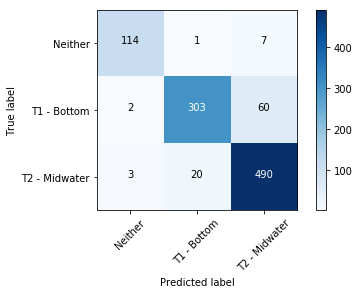

In [11]:
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
classes = ["Neither", "T1 - Bottom", "T2 - Midwater"]
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
